Successfully integrated scraped data.

--- EDA ---
Combined Data Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 98605 entries, 0 to 98604
Data columns (total 10 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Country Name         98605 non-null  object 
 1   CountryCode          98605 non-null  object 
 2   Indicator Name       98605 non-null  object 
 3   Indicator Code       98605 non-null  object 
 4   Year                 98605 non-null  int64  
 5   Value                45746 non-null  float64
 6   Region               98475 non-null  object 
 7   IncomeGroup          98475 non-null  object 
 8   SOURCE_NOTE          98475 non-null  object 
 9   SOURCE_ORGANIZATION  98475 non-null  object 
dtypes: float64(1), int64(1), object(8)
memory usage: 7.5+ MB

Missing Values:
Country Name               0
CountryCode                0
Indicator Name             0
Indicator Code             0
Year                     

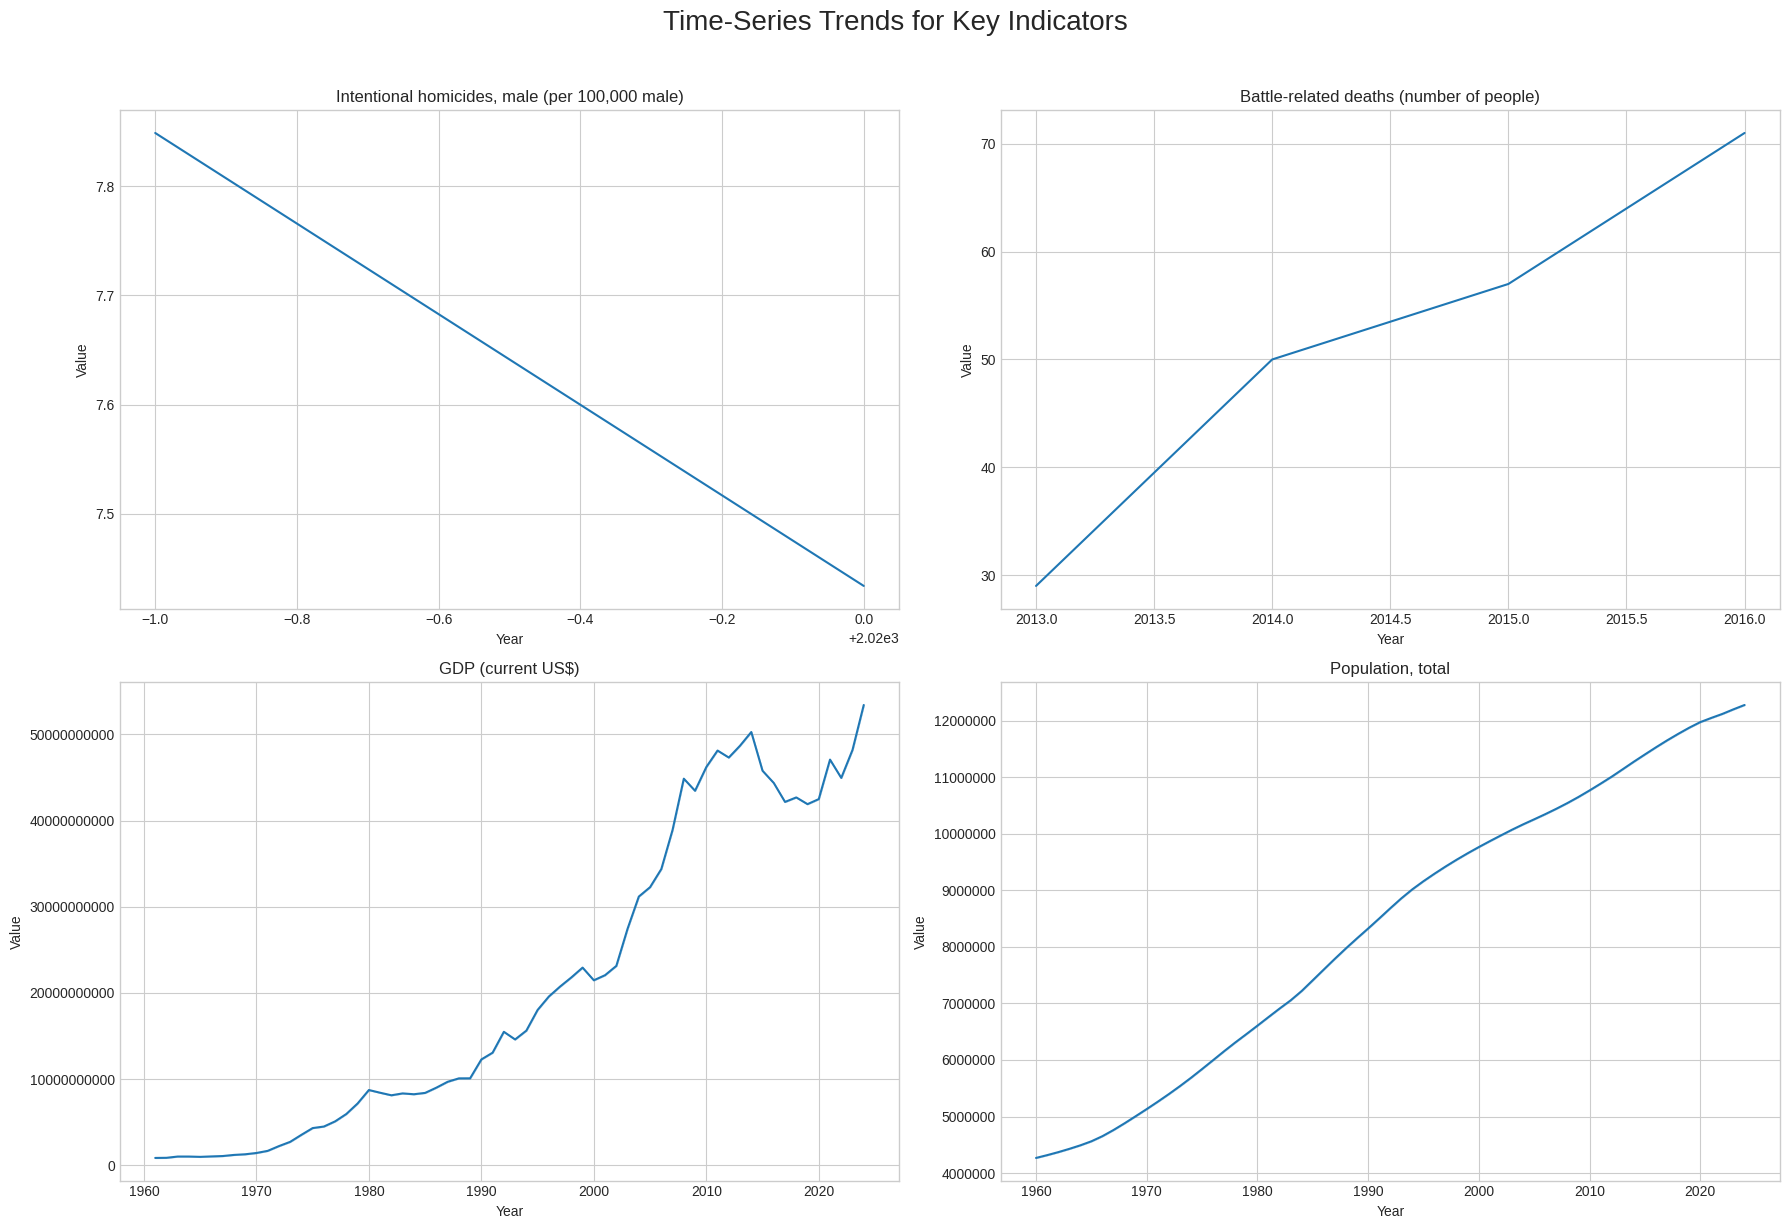

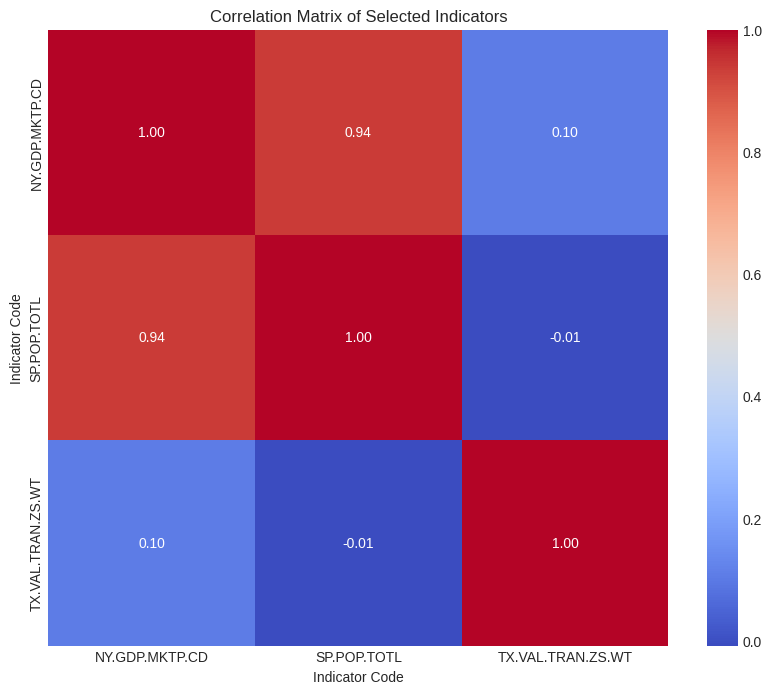

In [46]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import requests
import os

# Step 1: Web Scraping Function
def fetch_world_bank_data(country_code, indicator_codes, start_year, end_year):
    """Fetches data from the World Bank API."""
    all_data = []

    for indicator in indicator_codes:
        url = (f"http://api.worldbank.org/v2/country/{country_code}/indicator/{indicator}"
               f"?date={start_year}:{end_year}&format=json&per_page=1000")

        try:
            response = requests.get(url)
            response.raise_for_status()
            data = response.json()

            if len(data) > 1 and data[1]:
                for item in data[1]:
                    row = {
                        'Country Name': item.get('country', {}).get('value'),
                        'Country Code': item.get('countryiso3code'),
                        'Indicator Name': item.get('indicator', {}).get('value'),
                        'Indicator Code': item.get('indicator', {}).get('id'),
                        'Year': item.get('date'),
                        'Value': item.get('value')
                    }
                    all_data.append(row)

        except requests.exceptions.RequestException as e:
            print(f"Error fetching data from World Bank API: {e}")
            return pd.DataFrame()

    if not all_data:
        return pd.DataFrame()

    df = pd.DataFrame(all_data)
    df['Year'] = pd.to_numeric(df['Year'])
    df['Value'] = pd.to_numeric(df['Value'], errors='coerce')

    return df

# Step 2: ETL - Load Local Data
data_file = 'API_TUN_DS2_en_csv_v2_1037756.csv'
country_meta_file = 'Metadata_Country_API_TUN_DS2_en_csv_v2_1037756.csv'
indicator_meta_file = 'Metadata_Indicator_API_TUN_DS2_en_csv_v2_1037756.csv'

if not (os.path.exists(data_file) and os.path.exists(country_meta_file) and os.path.exists(indicator_meta_file)):
    print("Error: One or more local data files not found.")
    exit()

df_data = pd.read_csv(data_file, skiprows=4)
df_country_meta = pd.read_csv(country_meta_file)
df_indicator_meta = pd.read_csv(indicator_meta_file)

# Step 3: ETL - Transform and Merge Local Data
df_data.drop(df_data.tail(1).index, inplace=True)
df_data.rename(columns={'Country Code': 'CountryCode'}, inplace=True)
years = [col for col in df_data.columns if col.isdigit()]
id_vars = ['Country Name', 'CountryCode', 'Indicator Name', 'Indicator Code']
df_long = pd.melt(df_data, id_vars=id_vars, value_vars=years, var_name='Year', value_name='Value')
df_long['Year'] = pd.to_numeric(df_long['Year'])
df_long['Value'] = pd.to_numeric(df_long['Value'], errors='coerce')

if not df_country_meta.empty:
    df_country_meta.rename(columns={'Country Code': 'CountryCode'}, inplace=True)
    df_merged = pd.merge(df_long, df_country_meta[['CountryCode', 'Region', 'IncomeGroup']], on='CountryCode', how='left')
else:
    df_merged = df_long.copy()
    df_merged['Region'] = np.nan
    df_merged['IncomeGroup'] = np.nan

df_indicator_meta.rename(columns={'INDICATOR_CODE': 'Indicator Code'}, inplace=True)
df_merged = pd.merge(df_merged, df_indicator_meta[['Indicator Code', 'SOURCE_NOTE', 'SOURCE_ORGANIZATION']], on='Indicator Code', how='left')

# Step 4: ETL - Integrate Scraped Data
indicators_to_scrape = ['NY.GDP.MKTP.CD', 'SP.POP.TOTL']
scraped_df = fetch_world_bank_data(country_code='TUN', indicator_codes=indicators_to_scrape, start_year=1960, end_year=2024)

if not scraped_df.empty:
    scraped_df.rename(columns={'Country Code': 'CountryCode'}, inplace=True)
    df_combined = pd.concat([df_merged, scraped_df], ignore_index=True)
    df_combined['Value'] = pd.to_numeric(df_combined['Value'], errors='coerce')
    df_combined['Year'] = pd.to_numeric(df_combined['Year'])
    print("Successfully integrated scraped data.")
else:
    df_combined = df_merged.copy()
    print("No new data to add from scraping.")

# Step 5: EDA - Data Inspection
print("\n--- EDA ---")
print("Combined Data Info:")
df_combined.info()
print("\nMissing Values:")
print(df_combined.isnull().sum())
print("\nDescriptive Statistics:")
print(df_combined['Value'].describe())

# Step 6: Visualization
plt.style.use('seaborn-v0_8-whitegrid')
fig, axes = plt.subplots(2, 2, figsize=(18, 12))
fig.suptitle('Time-Series Trends for Key Indicators', fontsize=20, y=1.02)
indicators_to_plot = [
    'Intentional homicides, male (per 100,000 male)',
    'Battle-related deaths (number of people)',
    'GDP (current US$)',
    'Population, total'
]
for i, indicator in enumerate(indicators_to_plot):
    ax = axes[i // 2, i % 2]
    df_plot = df_combined[df_combined['Indicator Name'] == indicator]
    if not df_plot.empty:
        sns.lineplot(data=df_plot, x='Year', y='Value', ax=ax)
        ax.set_title(indicator)
        ax.set_xlabel('Year')
        ax.set_ylabel('Value')
        ax.ticklabel_format(style='plain', axis='y')
plt.tight_layout()
plt.savefig('time_series_trends_combined.png')
plt.show()

df_pivot = df_combined.pivot_table(index='Year', columns='Indicator Code', values='Value')
numerical_indicators = ['NY.GDP.MKTP.CD', 'SP.POP.TOTL', 'TX.VAL.TRAN.ZS.WT']
available_indicators = [ind for ind in numerical_indicators if ind in df_pivot.columns]
if available_indicators:
    df_corr = df_pivot[available_indicators].dropna(how='any')
    if not df_corr.empty:
        corr_matrix = df_corr.corr()
        plt.figure(figsize=(10, 8))
        sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
        plt.title('Correlation Matrix of Selected Indicators')
        plt.savefig('correlation_matrix_combined.png')
        plt.show()
    else:
        print("\nNot enough overlapping data points for the correlation matrix.")
else:
    print("\nSelected indicators not found.")